Import the packages and load the XLSX file with Pandas

In [275]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from datetime import datetime

file_path = "NP_task_eng_revised.xlsx"
df1 = pd.read_excel(file_path, sheet_name='Data_1')
df2 = pd.read_excel(file_path, sheet_name='Data_2')


1.  inspection data types

In [276]:
print(df1.dtypes)

PREFIX                    object
country_code              object
region_id                 object
first_activity            object
last_activity     datetime64[ns]
dtype: object


2. Convert to correct data types

In [277]:
df1["first_activity"] = pd.to_datetime(df1["first_activity"], errors='coerce')
df1['region_id'] = pd.to_numeric(df1['region_id'], errors='coerce')
print(df1.dtypes)

PREFIX                    object
country_code              object
region_id                float64
first_activity    datetime64[ns]
last_activity     datetime64[ns]
dtype: object


3. Connect to SQLite3

In [278]:
conn = sqlite3.connect("my_database.db")
df1.to_sql("Data_1", conn, index=False, if_exists='replace')

5005

4. Create a new tables with anomaly flags

In [279]:
query = """
SELECT *,
CASE
  WHEN PREFIX IS NULL AND CAST(strftime('%Y',first_activity) AS INTEGER) > 2025 THEN 'Future Dates + Missing PREFIX'
  WHEN PREFIX IS NULL THEN 'Missing PREFIX'
  WHEN PREFIX IN (SELECT PREFIX from Data_1 GROUP BY PREFIX HAVING count(*)>1) THEN 'Duplicate PREFIX'
  WHEN last_activity < first_activity THEN 'Invalid Dates'
  WHEN LENGTH(country_code) <> 2 THEN 'Invalid Country'
  WHEN region_id IS NULL AND first_activity IS NULL THEN 'Missing date + Invalid Region'
  WHEN region_id <=0 OR region_id IS NULL THEN 'Invalid Region'
  ELSE 'OK'
  END AS issue
FROM Data_1
"""

df_with_issues = pd.read_sql(query, conn)

1.1 Anomalies from the Data_1 table

The approach used was as follows:

- Identify the data type of each column.
- Detect missing or null values.
- Define rules for outliers, such as future dates, duplicate values, or values outside the expected range.
- Create a column flagging anomalies to be shared with the team for correction.

In [280]:
issues_only = df_with_issues[df_with_issues["issue"] != 'OK']
issues_only

,PREFIX,country_code,region_id,first_activity,last_activity,issue
159,14fd695f545x537ab749,PL,23.0,2015-09-27 13:55:12,2015-09-27 13:55:12,Duplicate PREFIX
169,14fd695f545x537ab749,PL,11.0,2015-10-07 15:58:21,2015-10-07 15:58:21,Duplicate PREFIX
728,14fd7a9d90ex1626dc75,RO,3.0,2015-11-20 10:21:01,2015-11-20 10:21:01,Duplicate PREFIX
844,14fd7a9d90ex1626dc75,PL,4.0,2015-09-21 18:00:58,2015-09-21 18:00:58,Duplicate PREFIX
2068,14fe06679c7x375369ds4c,PL,NaN,None,2015-11-17 22:38:50,Missing date + Invalid Region
2240,14fd6247ce1x19dc5f27,PL,13.0,2015-09-29 23:30:47,2015-09-27 23:30:47,Duplicate PREFIX
2276,14fd6247ce1x19dc5f27,PL,1.0,2015-09-19 20:39:39,2015-10-01 16:23:51,Duplicate PREFIX
2353,None,PL,23.0,2040-12-20 07:39:42,2040-12-20 07:39:42,Future Dates + Missing PREFIX


1.2 Quantitative and percentage distribution of user by region

The most represented region in this dataset is region_id 2.0, accounting for 13.67% of users. In contrast, the least represented region is region_id 23.0, with only 0.04% of users.

In [281]:
query2 = """
SELECT region_id,
count(*) AS user_count,
ROUND(count(*)*100.0/(select count(*) from Data_1),2) AS percentage
FROM Data_1
WHERE region_id IS NOT NULL
GROUP BY region_id
ORDER BY percentage desc
"""

df_2_tasks = pd.read_sql(query2, conn)
df_2_tasks


,region_id,user_count,percentage
0,2.0,684,13.67
1,6.0,575,11.49
2,1.0,573,11.45
3,3.0,388,7.75
4,4.0,366,7.31
5,7.0,341,6.81
6,5.0,332,6.63
7,15.0,303,6.05
8,8.0,280,5.59
9,11.0,236,4.72


1.3 Percentage of user who only did one activity and never came back

The percentage of user who did only one activity is 44.06%

In [282]:
# SQL approach
query3 = """
SELECT ROUND((SELECT count(*) FROM Data_1 WHERE first_activity=last_activity)*100.0
/ (SELECT count(*) FROM Data_1 WHERE first_activity IS NOT NULL AND last_activity IS NOT NULL),2) AS perc_unique_users
"""
df_3_tasks = pd.read_sql(query3, conn)
print(df_3_tasks)


   perc_unique_users
0              44.06


1.4 List of customers that did only 1 activity

Customers who performed only one activity can be identified by comparing the first_activity and last_activity columns; if both columns have the same value for a customer, it indicates a single activity.

The total number of unique customers meeting this criterion is 2,205.

In [283]:
query4 = """
SELECT PREFIX FROM Data_1 WHERE first_activity=last_activity
"""
df_4_tasks = pd.read_sql(query4, conn)
print(df_4_tasks)

                    PREFIX
0     125e7c32c75x1470d378
1     137178d76e7x697d40d9
2     13951d78ccax69d403c1
3     14fc1cfc985x33fe98a6
4     14fd4c69808x72b705a7
...                    ...
2200  14fd59804f0x10529bc8
2201  14fe196266fx621c950d
2202   14fe19e2cffxded6c21
2203  14fe1ae473ax5ae7e122
2204   14fe1b040e1xa171172

[2205 rows x 1 columns]


1.5 Actions suggested to activate users who did only one activity

I will provide the Marketing team, as well as the managers in charge of customer retention, with a specific list of users and their details. I would advise them to set up a customized marketing campaign for these users, offering attractive coupons or discounts to encourage them to visit the site again and make their first purchase. The campaign can also be targeted to regions with a high concentration of these users.

2. Stores the Data_2 dataframe to the database and inspection and data types

In [284]:
df2.to_sql("Data_2", conn, index=False, if_exists='replace')
print(df2.dtypes)

date                        datetime64[ns]
cnt_users                            int64
average transaction time           float64
Total reve                           int64
U_transactions                       int64
Price                                int64
Promo                              float64
dtype: object


2.1 Which of the prices suits the users best.

The most suitable price for users is 17 zł, because across all combinations of test dates and groups with the four different prices, 17 zł consistently generated the highest number of transactions, indicating that users are most willing to purchase at this price.

In [285]:
query5 = """
SELECT date, price, U_transactions
FROM (
SELECT date, price, U_transactions,
RANK() over (partition by date order by U_transactions DESC) AS rnk
FROM Data_2)
WHERE rnk = 1
"""

df_5_tasks = pd.read_sql(query5, conn)
df_5_tasks


,date,price,U_transactions
0,2012-03-13 00:00:00,17,426
1,2012-03-14 00:00:00,17,789
2,2012-03-15 00:00:00,17,734
3,2012-03-16 00:00:00,17,603
4,2012-03-17 00:00:00,17,542
5,2012-03-18 00:00:00,17,219
6,2012-03-19 00:00:00,17,203
7,2012-03-20 00:00:00,17,365


2.2 Interest changes in particular prices in the following days

The second most preferred price is 22zl; it ranked 2nd on 5 out of 8 test days, in the number of users who concluded a transaction.

The third most preferred price is 27 zł; it ranked 2nd on 3 out of 8 test days, but dropped to 4th on the last test day.


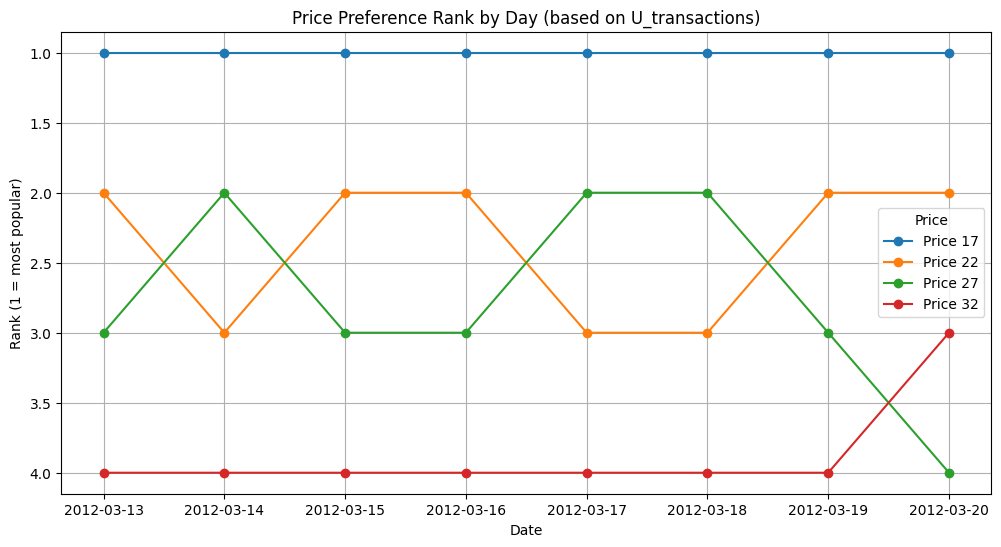

Price,17,22,27,32
date,,,,
2012-03-13,1.0,2.0,3.0,4.0
2012-03-14,1.0,3.0,2.0,4.0
2012-03-15,1.0,2.0,3.0,4.0
2012-03-16,1.0,2.0,3.0,4.0
2012-03-17,1.0,3.0,2.0,4.0
2012-03-18,1.0,3.0,2.0,4.0
2012-03-19,1.0,2.0,3.0,4.0
2012-03-20,1.0,2.0,4.0,3.0


In [286]:
df_6_tasks = pd.read_sql("SELECT * FROM Data_2", conn)
df_6_tasks["date"] = pd.to_datetime(df_6_tasks["date"], errors='coerce')
df_6_tasks["Users_pref_rank"] = df_6_tasks.groupby("date")["U_transactions"].rank(method="dense", ascending=False)
pivot_df = df_6_tasks.pivot(index="date", columns="Price", values="Users_pref_rank")

plt.figure(figsize=(12,6))
for price in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[price], marker="o", label=f"Price {price:.0f}")
plt.gca().invert_yaxis()  # rank 1 should be "top"
plt.title("Price Preference Rank by Day (based on U_transactions)")
plt.xlabel("Date")
plt.ylabel("Rank (1 = most popular)")
plt.legend(title="Price")
plt.grid(True)
plt.show()
pivot_df


2.3 The price that should be introduced is 17 zł, as it ranked 1st on every test date in terms of the number of users completing a transaction.

However, from a revenue perspective, 17 zł generated the lowest revenue on 7 out of 8 test dates. In comparison, the 27 zł price ranked 1st in total revenue on 3 out of 8 test dates and also ranked 2nd in user preference on 3 out of 8 test days.

For instance, on Wednesday, 2012-03-14, and Sunday, 2012-03-18, 27 zł ranked 2nd in user transactions but 1st in revenue generation. I suggest conducting new tests on these specific days of the week to further investigate price performance.

In [287]:
df_6_tasks["Revenue_rank"] = df_6_tasks.groupby("date")["Total reve"].rank(method="dense", ascending=False)
pivot_df_2 = df_6_tasks.pivot(index="date", columns="Price", values="Revenue_rank")
pivot_df_2

Price,17,22,27,32
date,,,,
2012-03-13,4.0,3.0,2.0,1.0
2012-03-14,4.0,3.0,1.0,2.0
2012-03-15,4.0,3.0,1.0,2.0
2012-03-16,4.0,3.0,2.0,1.0
2012-03-17,4.0,3.0,2.0,1.0
2012-03-18,3.0,4.0,1.0,2.0
2012-03-19,4.0,3.0,2.0,1.0
2012-03-20,4.0,3.0,2.0,1.0


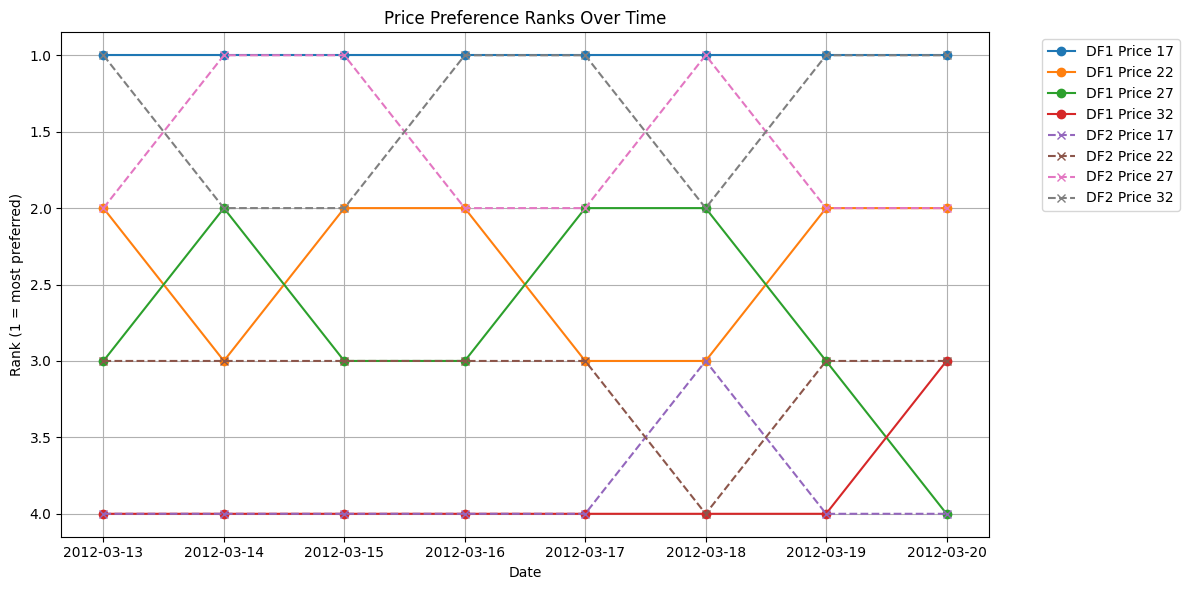

In [288]:
plt.figure(figsize=(12,6))

# Plot df1
for price in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[price], marker='o', label=f'DF1 Price {price}')

# Plot df2
for price in pivot_df_2.columns:
    plt.plot(pivot_df_2.index, pivot_df_2[price], marker='x', linestyle='--', label=f'DF2 Price {price}')

plt.gca().invert_yaxis()  # rank 1 at top
plt.xlabel('Date')
plt.ylabel('Rank (1 = most preferred)')
plt.title('Price Preference Ranks Over Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

conn.commit()
conn.close()
